In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
data= pd.read_excel('Orchids_processed_70percent.xlsx.xlsx', sheetname ='All')

In [3]:
data_Obt = data.filter(like='Pobt', axis=1)
data_Dil = data.filter(like='dil', axis=1)
data_S = data.filter(like='S', axis=1)
data_Stri = data.filter(like='stri', axis=1)
data_Hex = data.filter(like='hex', axis=1)

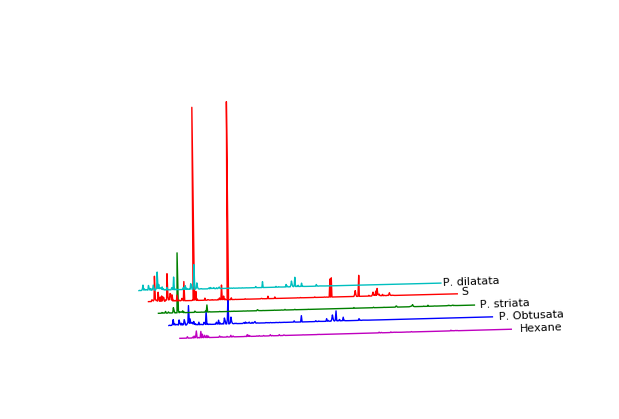

In [5]:
Size = data_Obt.shape[0]
MeanObt = np.zeros(Size)
MeanDil = np.zeros(Size)
MeanS = np.zeros(Size)
MeanStri = np.zeros(Size)
MeanHex = np.zeros(Size)

for i in range(0, Size):
    MeanObt[i] = np.mean(data_Obt.values[i, :])
    MeanDil[i] = np.mean(data_Obt.values[i, :])
    MeanS[i] = np.mean(data_S.values[i, :])
    MeanStri[i] = np.mean(data_Stri.values[i, :])
    MeanHex[i] = np.mean(data_Hex.values[i, :])

from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = Axes3D(fig)

ax.plot(range(0, Size),[1]*Size, MeanObt)
ax.plot(range(0, Size),[2]*Size, MeanStri)
ax.plot(range(0, Size), [3]*Size, MeanS)
ax.plot(range(0, Size),[4]*Size, MeanDil)
ax.plot(range(0, Size),[0]*Size, MeanHex)
ax.view_init(elev=10, azim=-100)
ax.axis('off')
ax.text(Size+10, 0, 0, "Hexane", (1, 0, 1), color='black', fontsize=8)
ax.text(Size+8, 1, 0, "P. Obtusata", (1, 0, 1), color='black', fontsize=8)
ax.text(Size+6, 2, 0, "P. striata", (1, 0, 1), color='black', fontsize=8)
ax.text(Size+4, 3, 0, "S", (1, 0, 1), color='black', fontsize=8)
ax.text(Size+2, 4, 0, "P. dilatata", (1, 0, 1), color='black', fontsize=8)


In [6]:
#data_Obt = data.filter(like='Pobt', axis=1)
#data_Dil = data.filter(like='dil', axis=1)
#data_S = data.filter(like='S', axis=1)
#data_Stri = data.filter(like='stri', axis=1)
#data_Hex = data.filter(like='hex', axis=1)
Hex = np.repeat(1, data_Hex.shape[1])
Dil = np.repeat(2, data_Dil.shape[1])
S = np.repeat(3, data_S.shape[1])
Str = np.repeat(4, data_Stri.shape[1])
Obt = np.repeat(0, data_Obt.shape[1])
Species = np.concatenate((Hex, Obt, Dil, S, Str))

datH = data_Hex.T
datO = data_Obt.T
datS = data_S.T
datSt = data_Stri.T
datD = data_Dil.T

dataAll = np.vstack((datH, datO, datS, datSt, datD))
dataAll.shape

from sklearn.decomposition import PCA

pcaExp = PCA()
pcaExp.fit(dataAll)
print pcaExp.components_.shape[0],'components come out of this decomposition'

73 components come out of this decomposition


4 components are required to explain 90% of the variance in the data


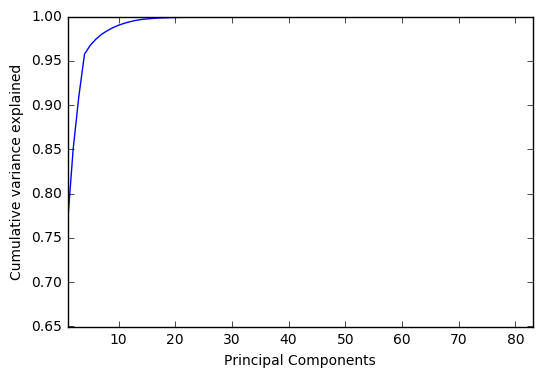

In [7]:
plt.plot(np.cumsum(pcaExp.explained_variance_ratio_))
plt.ylabel('Cumulative variance explained')
plt.xlabel('Principal Components')
plt.xlim(1,83)

CumSumExp = np.cumsum(pcaExp.explained_variance_ratio_)
for i in range(0, len(CumSumExp)):
    if CumSumExp[i] >= 0.9:
        print i+1, 'components are required to explain 90% of the variance in the data'
        break
        

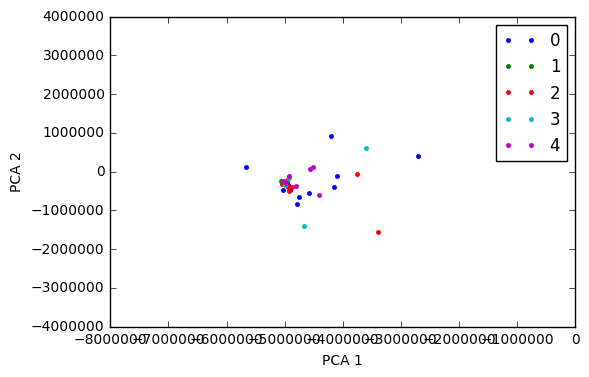

In [8]:
All_red = pcaExp.transform(dataAll)

for types in set(Species):
    plt.plot(All_red[Species==types, 0].flatten(),
            All_red[Species==types, 1].flatten(),
            '.')
    plt.legend(set(Species))
    plt.xlabel('PCA 1')
    plt.ylabel('PCA 2')
    plt.xlim(-0.8*1e7, 0)
    plt.ylim(-0.4*1e7, 0.4*1e7)

In [9]:
def test_train_id(N, test_frac):
    Samples = np.arange(0,N)
    Fraction = test_frac*N
    test = np.random.choice(range(0,N), round(Fraction))
    train = np.delete(Samples, test)
    return test, train   

In [10]:
from sklearn.neighbors import KNeighborsClassifier
Accuracy = np.zeros(100)
for i in range(100):
    test, train = test_train_id(73, 0.2)
    DataTest = dataAll[test, :]
    DataTrain = dataAll[train, :]
    pcaExp_train = PCA(4)
    pcaExp_train.fit(DataTrain)
    Train_red = pcaExp_train.transform(DataTrain)
    Test_red = pcaExp_train.transform(DataTest)
    model = KNeighborsClassifier(5)
    model.fit(Train_red, Species[train])
    Predict = model.predict(Test_red)
    Accuracy[i] = np.mean(Predict == Species[test])

print 'The mean accuracy of this classifier is', "%.2f" % np.mean(Accuracy), 'when trying to find 5 clusters (1 per species)'

C:\Anaconda2\lib\site-packages\ipykernel\__main__.py:4: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


The mean accuracy of this classifier is 0.48 when trying to find 5 clusters (1 per species)


In [11]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

def cross_val_class_accuracy(model, X, y, r, test_frac, reps):
    Accuracy = np.zeros(reps)
    for i in range(reps):
        test, train = test_train_id(73, test_frac)
        DataTest = X[test, :]
        DataTrain = X[train, :]
        pcaExp_train = PCA(r)
        pcaExp_train.fit(DataTrain)
        pcaExp_test = PCA(r)
        pcaExp_test.fit(DataTest)
        Train_red = pcaExp_train.transform(DataTrain)
        Test_red = pcaExp_test.transform(DataTest)
        mymodel = model
        model.fit(Train_red, y[train])
        Predict = model.predict(Test_red)
        Accuracy[i] = np.mean(Predict == y[test])
    cv_acc = np.mean(Accuracy)
    return cv_acc

In [ ]:
from sklearn.svm import SVC
from sklearn import tree

#LDA5 = cross_val_class_accuracy(LinearDiscriminantAnalysis(), dataAll, Species, 4, 0.2, 200)
#LDA20 = cross_val_class_accuracy(LinearDiscriminantAnalysis(), dataAll, Species, 4, 0.2, 200)
SVM20 = cross_val_class_accuracy(SVC(kernel='linear'), dataAll, Species, 4, 0.2, 200)
DT20 = cross_val_class_accuracy(tree.DecisionTreeClassifier(), dataAll, Species, 4, 0.2, 200) 

bar(range(4), [LDA5, LDA20, SVM20, DT20])
plt.ylim(0,0.35)
plt.ylabel('Accuracy')

C:\Anaconda2\lib\site-packages\ipykernel\__main__.py:4: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


In [ ]:
LDA5

In [ ]:
Hex = np.repeat(1, data_Hex.shape[1])
Dil = np.repeat(1, data_Dil.shape[1])
S = np.repeat(1, data_S.shape[1])
Str = np.repeat(1, data_Stri.shape[1])
Obt = np.repeat(0, data_Obt.shape[1])
Species2 = np.concatenate((Hex, Obt, Dil, S, Str))

KNN2 = cross_val_class_accuracy(KNeighborsClassifier(2), dataAll, Species2, 16, 0.2, 200)
LDA5 = cross_val_class_accuracy(LinearDiscriminantAnalysis(), dataAll, Species2, 4, 0.2, 200)
LDA20 = cross_val_class_accuracy(LinearDiscriminantAnalysis(), dataAll, Species2, 4, 0.2, 200)
SVM20 = cross_val_class_accuracy(SVC(kernel='linear'), dataAll, Species2, 4, 0.2, 200)
DT20 = cross_val_class_accuracy(tree.DecisionTreeClassifier(), dataAll, Species2, 4, 0.2, 200) 

bar(range(5), [KNN2, LDA5, LDA20, SVM20, DT20])
plt.ylim(0,0.35)
plt.ylabel('Accuracy')